# Phase 4 Project Notebook
- Author: Jonathan Holt
- Data Science Flex

## Business Problem
- What are the top 5 best zip codes for us to invest in?

### Criteria:
<b>In my meeting with the Company, I was given the following directions by the lead investors:</b>

1. The Company is is looking to invest 500,000 per home per zip code.
2. They want to diversify by investing in 5 different zip codes, in 5 different states.
3. The Company would like to maximize their ROI per home. 
4. The Company would like to minmize risk. They want "sure thing" investments.

<b> Based on these assumptions, I have set the following criteria to identify the "best" zip codes to invest in:</b>


## Questions to Answer

1. What is the average (mean) home price for zip codes?
    a. also by: State, Metro Region, etc.
2. Which zip codes performed above expectations?
3. Do the top performing zip codes have any identifiers?


## What Models & Metrics I plan on using

## Helper Functions
- Functions provided by Flatiron

In [28]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [108]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    #melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted = pd.melt(df, id_vars=['ZipCode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [30]:
#function for displaying money in millions.
def display_millions(x, pos):
    return '${:1.1f}M'.format(x*1e-6)

# PreProcessing

## Loading Data

In [31]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.max_rows', 1500) #change the amount of rows displayed

pd.options.display.float_format = '{:,.2f}'.format 

In [32]:
ts = pd.read_csv("zillow_data.csv")

In [33]:
ts.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"235,700.00","236,900.00","236,700.00",...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,"210,400.00","212,200.00","212,200.00",...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,"498,100.00","500,900.00","503,100.00",...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"77,300.00","77,300.00","77,300.00",...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


##  Changing RegionName to ZipCode
A google search shows that RegionName is the ZipCode for each Region. However, upon sorting, I discovered that any ZipCode beginning with a 0 was ignoring it and displaying as a 4 digit number. I will use the .str().zfill() method to ensure that all RegionNames are displaying the as 5 digits.

In [34]:
ts['RegionName'] = ts['RegionName'].astype(str).str.zfill(5)
ts.rename(columns={'RegionName': 'ZipCode'}, inplace=True)

## Checking for Null Values

In [35]:
ts.isnull().sum()

RegionID         0
ZipCode          0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

### Analysis
There are many Null Values. 
- For categorical data, 7% of Metro are null (1043 of 14,723).
- Dates from 1996 - mid 2003, also have 7% null values.
- Then it starts to get better. 6% null and decreasing.

- I will keep all of the nulls for now. I will likely care the most about the most recent data, and that is where the records are most complete. 

### Metro
- The null values for Metro are because of rural zip codes that aren't close enough to a metro area to be classified as such. I will create a new value for Metro of 'no_metro' to represent these rural zip codes. 
- NOTE: for any analysis of Metro areas, 'no_metro' should be excluded as these zip codes are NOT part of the same area.

In [36]:
ts['Metro'].value_counts().head()

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
Name: Metro, dtype: int64

In [37]:
ts['Metro'].fillna('no_metro', inplace=True)

In [38]:
ts['Metro'].value_counts().head()

no_metro                          1043
New York                           779
Los Angeles-Long Beach-Anaheim     347
Chicago                            325
Philadelphia                       281
Name: Metro, dtype: int64

In [39]:
ts.isna().sum()

RegionID         0
ZipCode          0
City             0
State            0
Metro            0
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

- All remaining null values are for the time series data. I will leave them as is for now, and deal with them later on as it will likely depend on how I am grouping the data, etc.

## Changing dtype for all housing data to float.

In [40]:
ts[ts.columns[7:]] = ts[ts.columns[7:]].astype(float)

# Creating avg_home_df
- Create Dataset that is just the mean values to do analysis of trends, etc for baseline.
- then I can look for zip codes that have the best performance above and beyond baseline.

In [41]:
data_values = ts.iloc[:, 7:]
data_values['2018-04'].dtype

dtype('float64')

In [42]:
avg_home_df = pd.DataFrame(data_values.mean())
avg_home_df = avg_home_df.reset_index()
avg_home_df['time'] = pd.to_datetime(avg_home_df['index'])
avg_home_df.set_index('time', inplace=True)
avg_home_df.drop(columns=('index'), inplace=True)
avg_home_df.rename(columns={0: 'home_value'}, inplace=True)

In [43]:
avg_home_df.head()

,home_value
time,
1996-04-01,"118,299.12"
1996-05-01,"118,419.04"
1996-06-01,"118,537.42"
1996-07-01,"118,653.07"
1996-08-01,"118,780.25"


## Analysis of Avg_Home_DF

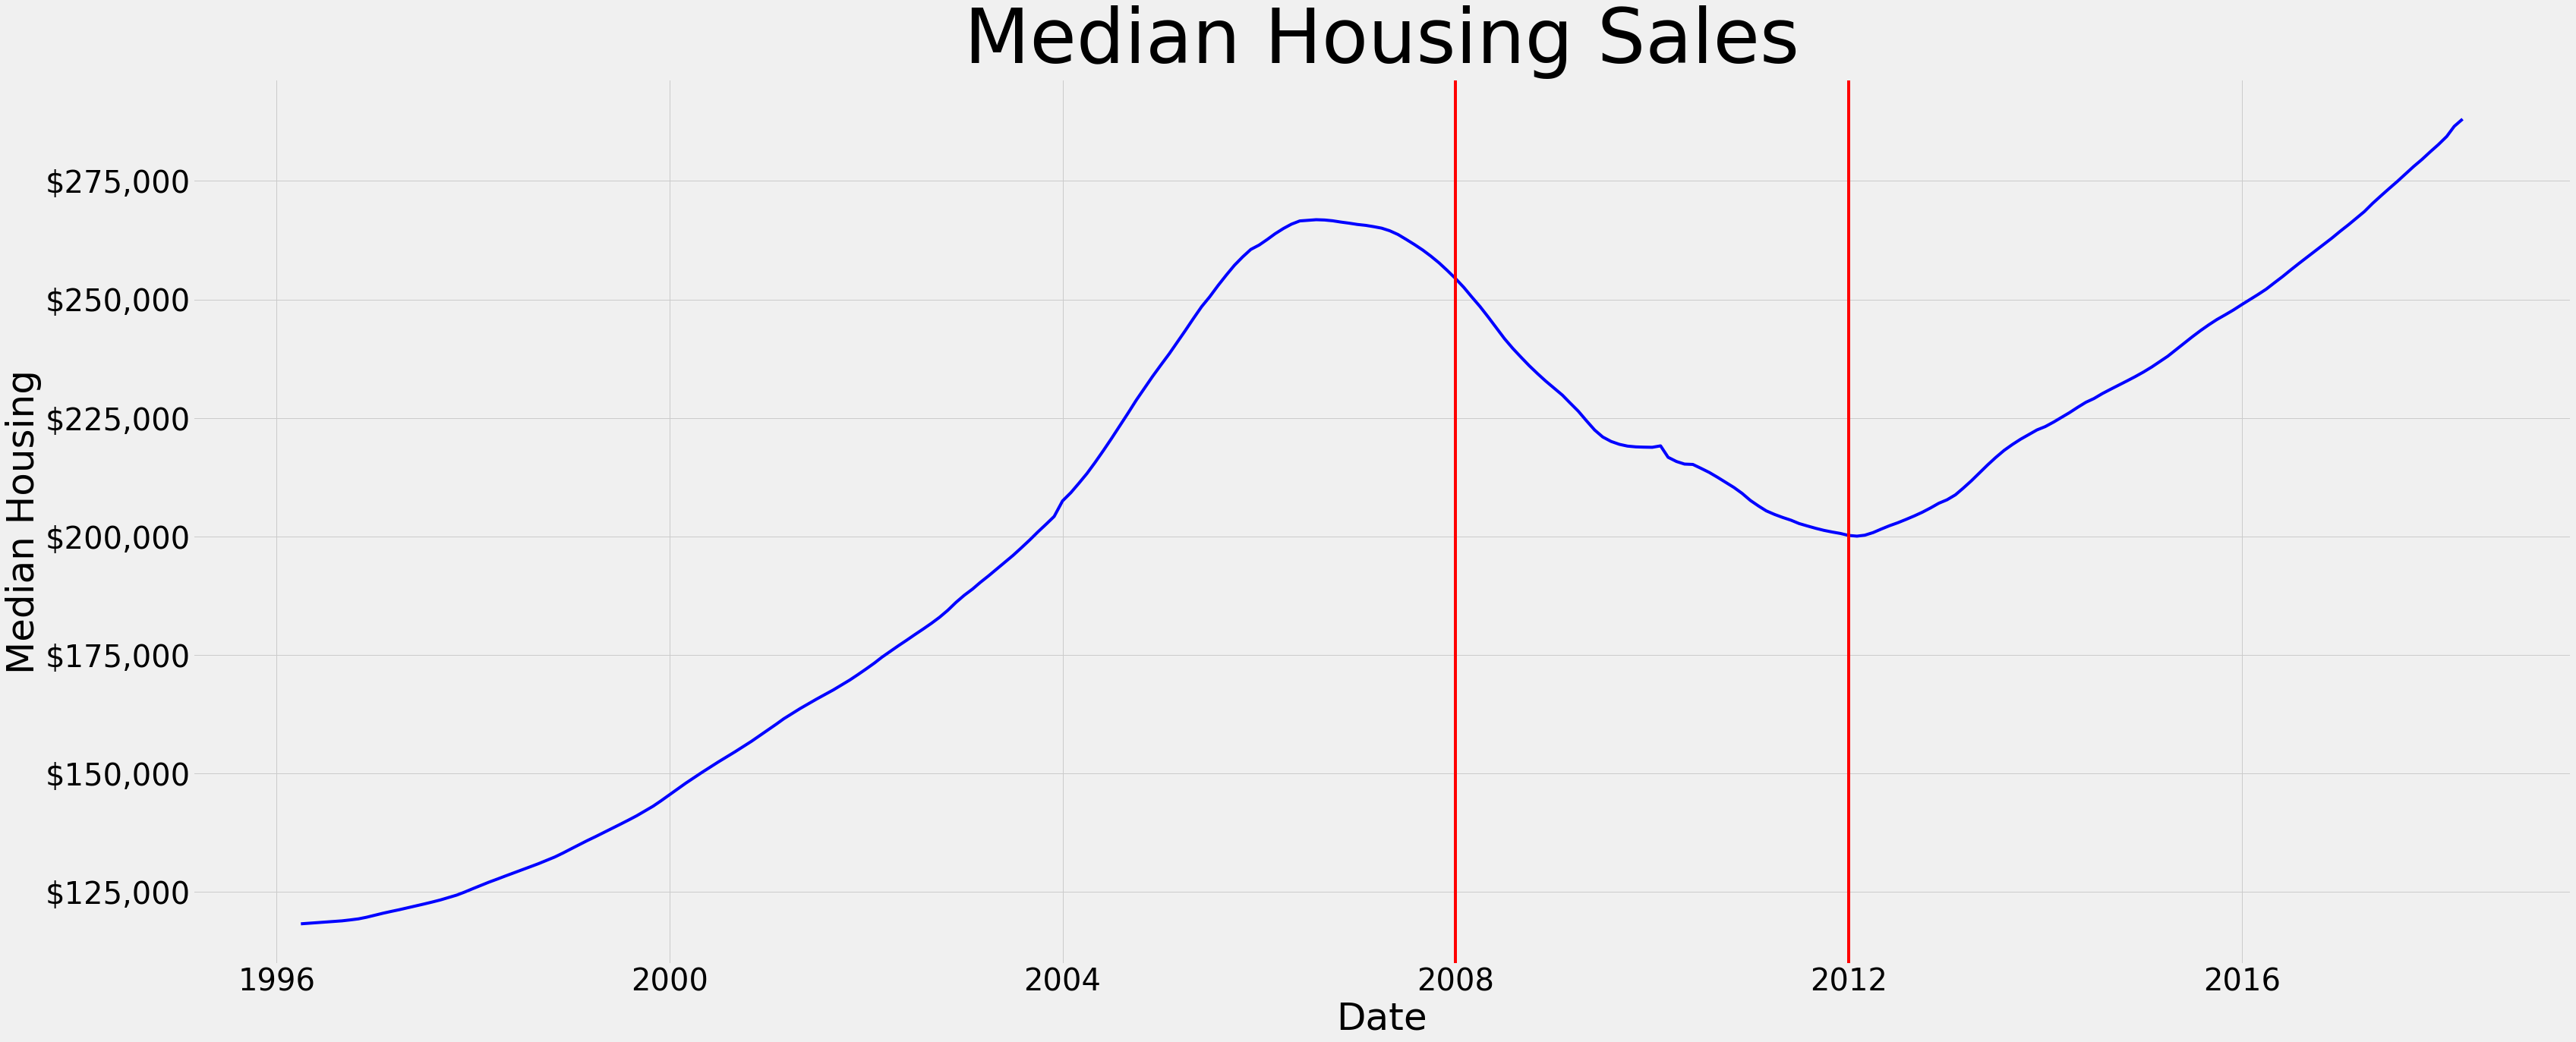

In [44]:
fig, ax = plt.subplots(figsize=(50, 20))
p = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='blue');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01', color='red') #housing market crash begins
y2 = p.axvline('2012-01', color='red') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

## Analysis:
- Home Sales Values are on an upward trend, however there was a significant dip from aprox 2006 - 2012, before recovering and trending upward again.
- The dip was due to the US Housing Market Crash of 2008. (https://en.wikipedia.org/wiki/United_States_housing_bubble)

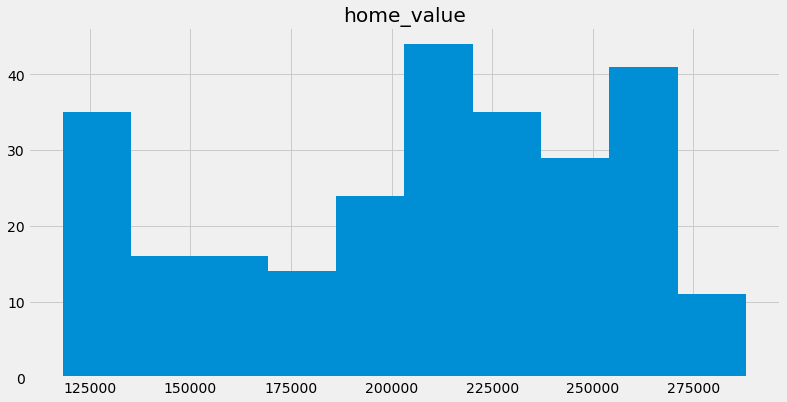

In [45]:
avg_home_df.hist(figsize = (12,6))
plt.show()

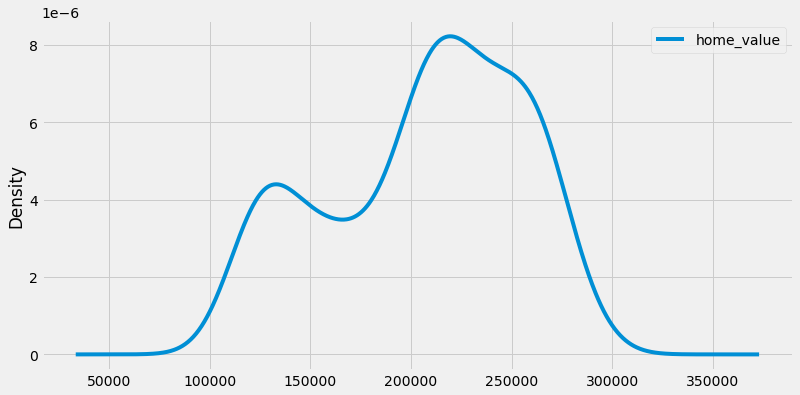

In [46]:
avg_home_df.plot(kind='kde', figsize = (12,6))
plt.show()

In [47]:
# Determine rolling statistics
#roll_mean = avg_home_df.rolling(window=12, center=False).mean()
#roll_std = avg_home_df.rolling(window=12, center=False).std()

## Dickey Fuller Test

In [48]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(avg_home_df)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                 -1.89
p-value                         0.34
#Lags Used                      2.00
Number of Observations Used   262.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


# Feature Engineering

- I want to add additional features to the DataSet so that I can determine what data I want to analyze further and ultimately model.
- add: Region Mean, Region Growth, etc
- THE POINT IS TO IDENTIFY WHICH ZIPS ARE THE BEST PERFORMING SO I CAN NARROW DOWN THE DATA TO CAPTURE!!!!

In [49]:
new_df = ts.copy()

In [50]:
#making sure that all the data fields were changed to floats
new_df['2018-04'].dtype

dtype('float64')

In [51]:
new_df['mean'] = data_values.apply(lambda x: x.mean(), axis=1)

In [52]:
new_df.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,"1,007,500.00","1,007,800.00","1,009,600.00","1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00","1,030,600.00","743,978.87"
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"235,700.00","236,900.00","236,700.00",...,"310,000.00","312,500.00","314,100.00","315,000.00","316,600.00","318,100.00","319,600.00","321,100.00","321,800.00","219,655.85"
2,91982,77494,Katy,TX,Houston,Harris,3,"210,400.00","212,200.00","212,200.00",...,"320,600.00","320,200.00","320,400.00","320,800.00","321,200.00","321,200.00","323,000.00","326,900.00","329,900.00","262,110.57"
3,84616,60614,Chicago,IL,Chicago,Cook,4,"498,100.00","500,900.00","503,100.00",...,"1,287,700.00","1,287,400.00","1,291,500.00","1,296,600.00","1,299,000.00","1,302,700.00","1,306,400.00","1,308,500.00","1,307,000.00","974,139.25"
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"77,300.00","77,300.00","77,300.00",...,"119,400.00","120,000.00","120,300.00","120,300.00","120,300.00","120,300.00","120,500.00","121,000.00","121,500.00","101,875.47"


In [53]:
#new_df['min'] = data_values.apply(lambda x: x.min(), axis=1)
#new_df['max'] = data_values.apply(lambda x: x.max(), axis=1)
#new_df['delta'] = new_df.apply(lambda x: x['2018-04'] - x['min'], axis=1)
#new_df['delta_percent'] = new_df.apply(lambda x: x['delta'] / x['min'], axis=1)

# Analysis of New_df

## Top Zip Codes by Mean Value

In [54]:
new_df.sort_values('mean', ascending=False).head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean
272,61635,10021,New York,NY,New York,New York,273,nan,nan,nan,...,"18,703,500.00","18,605,300.00","18,569,400.00","18,428,800.00","18,307,100.00","18,365,900.00","18,530,400.00","18,337,700.00","17,894,900.00","12,854,267.44"
20,61625,10011,New York,NY,New York,New York,21,nan,nan,nan,...,"12,112,600.00","12,036,600.00","12,050,100.00","12,016,300.00","11,946,500.00","11,978,100.00","11,849,300.00","11,563,000.00","11,478,300.00","7,755,843.75"
508,61628,10014,New York,NY,New York,New York,509,nan,nan,nan,...,"9,958,800.00","9,828,700.00","9,631,000.00","9,515,800.00","9,492,800.00","9,524,900.00","9,373,400.00","9,119,600.00","8,959,300.00","6,836,902.33"
21,61703,10128,New York,NY,New York,New York,22,"3,676,700.00","3,704,200.00","3,729,600.00",...,"7,422,400.00","7,417,600.00","7,427,300.00","7,371,400.00","7,342,700.00","7,353,300.00","7,350,300.00","7,363,000.00","7,386,600.00","5,085,435.85"
10237,97518,94027,Atherton,CA,San Francisco,San Mateo,10238,"1,179,200.00","1,184,300.00","1,189,700.00",...,"6,197,800.00","6,250,200.00","6,315,400.00","6,429,100.00","6,581,800.00","6,705,000.00","6,764,600.00","6,788,400.00","6,796,500.00","3,487,129.06"


## Analysis:
While this is a good metric to have, it doesn't tell me enough. Areas with high home values may have always had higher home values. I need to determine the value over time.

# Analysis DataFrame

<b> First, I will slice out the top quartile (75%) of mean home values. </b>

In [55]:
avg_home_df.describe()

,home_value
count,265.00
mean,"206,661.51"
std,"47,809.38"
min,"118,299.12"
25%,"168,653.36"
50%,"215,113.13"
75%,"245,934.66"
max,"288,039.94"


<b>The top Quartile of avg US home values starts at 245,934. I will only be interested in Zip Codes that have a mean value of 246,000.</b>

In [56]:
new_df.describe()

,RegionID,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean
count,"14,723.00","14,723.00","13,684.00","13,684.00","13,684.00","13,684.00","13,684.00","13,684.00","13,684.00","13,684.00",...,"14,723.00","14,723.00","14,723.00","14,723.00","14,723.00","14,723.00","14,723.00","14,723.00","14,723.00","14,723.00"
mean,"81,075.01","7,362.00","118,299.12","118,419.04","118,537.42","118,653.07","118,780.25","118,927.53","119,120.52","119,345.35",...,"274,865.77","276,464.62","278,033.19","279,520.86","281,095.32","282,657.06","284,368.69","286,511.38","288,039.94","205,653.02"
std,"31,934.12","4,250.31","86,002.51","86,155.67","86,309.23","86,467.95","86,650.94","86,872.08","87,151.85","87,479.81",...,"361,467.76","362,756.27","364,460.95","365,600.33","367,045.39","369,572.74","371,773.91","372,461.23","372,054.40","233,945.10"
min,"58,196.00",1.00,"11,300.00","11,500.00","11,600.00","11,800.00","11,800.00","12,000.00","12,100.00","12,200.00",...,"14,500.00","14,700.00","14,800.00","14,500.00","14,300.00","14,100.00","13,900.00","13,800.00","13,800.00","18,660.20"
25%,"67,174.50","3,681.50","68,800.00","68,900.00","69,100.00","69,200.00","69,375.00","69,500.00","69,600.00","69,800.00",...,"127,500.00","128,200.00","128,700.00","129,250.00","129,900.00","130,600.00","131,050.00","131,950.00","132,400.00","102,711.70"
50%,"78,007.00","7,362.00","99,500.00","99,500.00","99,700.00","99,700.00","99,800.00","99,900.00","99,950.00","100,100.00",...,"189,600.00","190,500.00","191,400.00","192,500.00","193,400.00","194,100.00","195,000.00","196,700.00","198,100.00","150,634.72"
75%,"90,920.50","11,042.50","143,200.00","143,300.00","143,225.00","143,225.00","143,500.00","143,700.00","143,900.00","144,125.00",...,"306,650.00","308,500.00","309,800.00","311,700.00","313,400.00","315,100.00","316,850.00","318,850.00","321,100.00","235,686.04"
max,"753,844.00","14,723.00","3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00","3,813,500.00","3,849,600.00","3,888,900.00",...,"18,703,500.00","18,605,300.00","18,569,400.00","18,428,800.00","18,307,100.00","18,365,900.00","18,530,400.00","18,337,700.00","17,894,900.00","12,854,267.44"


In [57]:
recent_df = new_df[new_df['mean'] >= 246000]

In [58]:
recent_df.describe()

,RegionID,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean
count,"3,440.00","3,440.00","3,354.00","3,354.00","3,354.00","3,354.00","3,354.00","3,354.00","3,354.00","3,354.00",...,"3,440.00","3,440.00","3,440.00","3,440.00","3,440.00","3,440.00","3,440.00","3,440.00","3,440.00","3,440.00"
mean,"82,309.50","6,091.64","214,679.25","214,849.64","215,019.29","215,185.15","215,381.66","215,626.48","215,975.07","216,403.25",...,"626,988.81","630,759.36","634,633.81","638,205.41","642,048.17","646,140.61","650,391.72","655,182.27","658,300.58","445,705.83"
std,"38,428.44","4,003.58","120,099.88","120,520.01","120,938.39","121,369.76","121,844.71","122,395.30","123,046.12","123,781.12",...,"617,179.05","618,617.61","621,000.37","622,131.96","623,870.19","628,120.37","631,549.01","631,049.11","628,628.09","388,191.53"
min,"58,197.00",1.00,"67,100.00","68,100.00","69,100.00","70,200.00","71,300.00","72,500.00","73,700.00","74,900.00",...,"227,200.00","232,400.00","238,100.00","240,200.00","238,100.00","235,500.00","234,100.00","234,200.00","233,800.00","246,156.98"
25%,"62,038.75","2,681.75","155,225.00","155,300.00","155,225.00","155,300.00","155,300.00","155,500.00","155,725.00","155,725.00",...,"376,575.00","377,875.00","378,950.00","381,350.00","383,250.00","385,375.00","387,700.00","390,025.00","391,875.00","286,609.43"
50%,"76,465.50","5,675.50","184,300.00","184,650.00","184,850.00","185,000.00","185,000.00","184,850.00","184,900.00","185,150.00",...,"467,350.00","470,400.00","473,200.00","475,500.00","477,100.00","478,600.00","481,800.00","486,350.00","489,200.00","353,714.53"
75%,"96,596.25","9,182.25","235,475.00","235,600.00","235,900.00","236,300.00","236,600.00","236,700.00","236,675.00","236,700.00",...,"670,150.00","672,600.00","677,325.00","682,750.00","687,700.00","691,775.00","696,425.00","698,275.00","699,850.00","480,623.77"
max,"753,843.00","14,723.00","3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00","3,813,500.00","3,849,600.00","3,888,900.00",...,"18,703,500.00","18,605,300.00","18,569,400.00","18,428,800.00","18,307,100.00","18,365,900.00","18,530,400.00","18,337,700.00","17,894,900.00","12,854,267.44"


# Last 3 Years DataFrame

In [75]:
recent_data_2 = new_df.copy()

In [76]:
recent_data_2.iloc[:, 7:-41]

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12
0,"334,200.00","335,400.00","336,500.00","337,600.00","338,500.00","339,500.00","340,400.00","341,300.00","342,600.00","344,400.00",...,"863,900.00","872,900.00","883,300.00","889,500.00","892,800.00","893,600.00","891,300.00","889,900.00","891,500.00","893,000.00"
1,"235,700.00","236,900.00","236,700.00","235,400.00","233,300.00","230,600.00","227,300.00","223,400.00","219,600.00","215,800.00",...,"234,200.00","235,400.00","236,600.00","238,500.00","240,500.00","242,600.00","244,700.00","246,300.00","247,600.00","249,600.00"
2,"210,400.00","212,200.00","212,200.00","210,700.00","208,300.00","205,500.00","202,500.00","199,800.00","198,300.00","197,300.00",...,"282,100.00","284,200.00","286,000.00","288,300.00","290,700.00","293,300.00","295,900.00","298,300.00","300,200.00","301,300.00"
3,"498,100.00","500,900.00","503,100.00","504,600.00","505,500.00","505,700.00","505,300.00","504,200.00","503,600.00","503,400.00",...,"1,149,900.00","1,155,200.00","1,160,100.00","1,163,300.00","1,167,700.00","1,173,900.00","1,175,100.00","1,173,500.00","1,175,500.00","1,178,500.00"
4,"77,300.00","77,300.00","77,300.00","77,300.00","77,400.00","77,500.00","77,600.00","77,700.00","77,700.00","77,800.00",...,"112,000.00","112,500.00","112,700.00","113,100.00","113,900.00","114,400.00","114,500.00","114,400.00","114,300.00","114,400.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,"94,600.00","94,300.00","94,000.00","93,700.00","93,400.00","93,200.00","93,000.00","92,900.00","92,700.00","92,600.00",...,"187,600.00","187,300.00","187,300.00","188,100.00","189,600.00","190,800.00","189,800.00","188,500.00","189,400.00","191,100.00"
14719,"92,700.00","92,500.00","92,400.00","92,200.00","92,100.00","91,900.00","91,700.00","91,300.00","90,900.00","90,500.00",...,"180,000.00","180,000.00","181,400.00","181,900.00","182,200.00","183,300.00","185,800.00","187,700.00","187,500.00","184,900.00"
14720,"57,100.00","57,300.00","57,500.00","57,700.00","58,000.00","58,200.00","58,400.00","58,700.00","59,100.00","59,500.00",...,"105,100.00","105,200.00","104,800.00","104,200.00","104,200.00","104,700.00","104,600.00","104,600.00","104,800.00","104,800.00"
14721,"191,100.00","192,400.00","193,700.00","195,000.00","196,300.00","197,700.00","199,100.00","200,700.00","202,600.00","204,900.00",...,"528,900.00","532,000.00","535,200.00","538,500.00","538,300.00","543,700.00","551,400.00","552,800.00","547,100.00","537,900.00"


In [77]:
recent_data_2= recent_data_2.drop(recent_data_2.iloc[:, 7:-41], axis=1)

In [79]:
recent_data_2.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,2015-01,2015-02,2015-03,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean
0,84654,60657,Chicago,IL,Chicago,Cook,1,"893,000.00","895,000.00","901,200.00",...,"1,007,500.00","1,007,800.00","1,009,600.00","1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00","1,030,600.00","743,978.87"
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"251,400.00","253,000.00","255,200.00",...,"310,000.00","312,500.00","314,100.00","315,000.00","316,600.00","318,100.00","319,600.00","321,100.00","321,800.00","219,655.85"
2,91982,77494,Katy,TX,Houston,Harris,3,"301,700.00","302,400.00","303,600.00",...,"320,600.00","320,200.00","320,400.00","320,800.00","321,200.00","321,200.00","323,000.00","326,900.00","329,900.00","262,110.57"
3,84616,60614,Chicago,IL,Chicago,Cook,4,"1,176,400.00","1,174,600.00","1,178,500.00",...,"1,287,700.00","1,287,400.00","1,291,500.00","1,296,600.00","1,299,000.00","1,302,700.00","1,306,400.00","1,308,500.00","1,307,000.00","974,139.25"
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"114,700.00","115,000.00","115,000.00",...,"119,400.00","120,000.00","120,300.00","120,300.00","120,300.00","120,300.00","120,500.00","121,000.00","121,500.00","101,875.47"


In [80]:
recent_data_2.drop(columns = ['mean'], inplace=True)

In [81]:
recent_data_2.head(2)

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,2015-01,2015-02,2015-03,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,"893,000.00","895,000.00","901,200.00",...,"1,005,500.00","1,007,500.00","1,007,800.00","1,009,600.00","1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00","1,030,600.00"
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"251,400.00","253,000.00","255,200.00",...,"308,000.00","310,000.00","312,500.00","314,100.00","315,000.00","316,600.00","318,100.00","319,600.00","321,100.00","321,800.00"


In [83]:
recent_data_2['mean_3yr'] = recent_data_2.iloc[:, 7:].apply(lambda x: x.mean(), axis=1)

In [84]:
recent_data_2['ROI'] = recent_data_2.iloc[:, 7:].apply(lambda x: x['2018-04'] - x['2015-01'], axis=1)
recent_data_2['ROI%'] = recent_data_2.iloc[:, 7:].apply(lambda x: x['ROI'] / x['2015-01'], axis=1)

In [85]:
recent_data_2.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,2015-01,2015-02,2015-03,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,mean_3yr,ROI,ROI%
0,84654,60657,Chicago,IL,Chicago,Cook,1,"893,000.00","895,000.00","901,200.00",...,"1,009,600.00","1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00","1,030,600.00","971,970.00","137,600.00",0.15
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"251,400.00","253,000.00","255,200.00",...,"314,100.00","315,000.00","316,600.00","318,100.00","319,600.00","321,100.00","321,800.00","291,002.50","70,400.00",0.28
2,91982,77494,Katy,TX,Houston,Harris,3,"301,700.00","302,400.00","303,600.00",...,"320,400.00","320,800.00","321,200.00","321,200.00","323,000.00","326,900.00","329,900.00","320,937.50","28,200.00",0.09
3,84616,60614,Chicago,IL,Chicago,Cook,4,"1,176,400.00","1,174,600.00","1,178,500.00",...,"1,291,500.00","1,296,600.00","1,299,000.00","1,302,700.00","1,306,400.00","1,308,500.00","1,307,000.00","1,249,762.50","130,600.00",0.11
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"114,700.00","115,000.00","115,000.00",...,"120,300.00","120,300.00","120,300.00","120,300.00","120,500.00","121,000.00","121,500.00","116,845.00","6,800.00",0.06


In [88]:
recent_data_2.iloc[:, 8 :-4]

,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,...,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03
0,"895,000.00","901,200.00","909,400.00","915,000.00","916,700.00","917,700.00","919,800.00","925,800.00","937,100.00","948,200.00",...,"999,100.00","1,005,500.00","1,007,500.00","1,007,800.00","1,009,600.00","1,013,300.00","1,018,700.00","1,024,400.00","1,030,700.00","1,033,800.00"
1,"253,000.00","255,200.00","258,000.00","261,200.00","264,700.00","268,400.00","271,400.00","273,600.00","275,200.00","276,400.00",...,"307,000.00","308,000.00","310,000.00","312,500.00","314,100.00","315,000.00","316,600.00","318,100.00","319,600.00","321,100.00"
2,"302,400.00","303,600.00","306,200.00","309,100.00","311,900.00","314,100.00","316,300.00","319,000.00","322,000.00","324,300.00",...,"320,900.00","321,000.00","320,600.00","320,200.00","320,400.00","320,800.00","321,200.00","321,200.00","323,000.00","326,900.00"
3,"1,174,600.00","1,178,500.00","1,185,700.00","1,192,900.00","1,198,800.00","1,200,400.00","1,198,900.00","1,200,200.00","1,207,400.00","1,218,600.00",...,"1,289,000.00","1,289,800.00","1,287,700.00","1,287,400.00","1,291,500.00","1,296,600.00","1,299,000.00","1,302,700.00","1,306,400.00","1,308,500.00"
4,"115,000.00","115,000.00","115,200.00","115,600.00","115,900.00","115,600.00","115,400.00","115,400.00","115,500.00","115,800.00",...,"118,900.00","119,100.00","119,400.00","120,000.00","120,300.00","120,300.00","120,300.00","120,300.00","120,500.00","121,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,"193,300.00","193,400.00","192,000.00","191,200.00","190,900.00","190,900.00","191,100.00","191,900.00","191,400.00","190,700.00",...,"215,400.00","216,800.00","217,700.00","218,600.00","218,500.00","218,100.00","216,400.00","213,100.00","209,800.00","209,200.00"
14719,"181,900.00","182,300.00","184,400.00","186,300.00","188,300.00","190,800.00","191,800.00","189,500.00","187,700.00","186,800.00",...,"197,300.00","202,100.00","208,400.00","212,200.00","215,200.00","214,300.00","213,100.00","213,700.00","218,300.00","222,700.00"
14720,"104,400.00","104,400.00","105,000.00","105,900.00","106,800.00","107,500.00","107,700.00","107,800.00","108,300.00","108,600.00",...,"121,100.00","121,800.00","122,800.00","124,600.00","126,700.00","128,800.00","130,600.00","131,700.00","132,500.00","133,000.00"
14721,"517,500.00","538,300.00","552,700.00","545,800.00","536,100.00","538,300.00","537,800.00","539,000.00","543,500.00","556,000.00",...,"647,300.00","662,800.00","671,200.00","682,400.00","695,600.00","695,500.00","694,700.00","706,400.00","705,300.00","681,500.00"


In [89]:
recent_data_2= recent_data_2.drop(recent_data_2.iloc[:, 8:-4], axis=1)

In [100]:
recent_data_2 = recent_data_2[recent_data_2['2018-04'] <= 500000]

### searching for the best ROI percentage over the last 3 years with a current (april 2018) value of 500,000 or less

In [101]:
recent_data_2.sort_values('2018-04', ascending=False).head(100)

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,2015-01,2018-04,mean_3yr,ROI,ROI%
6041,399553,18902,Buckingham,PA,Philadelphia,Bucks,6042,"456,000.00","499,700.00","471,942.50","43,700.00",0.10
2275,91655,77006,Houston,TX,Houston,Harris,2276,"461,800.00","499,600.00","472,747.50","37,800.00",0.08
2053,96843,92373,Redlands,CA,Riverside,San Bernardino,2054,"419,500.00","499,300.00","459,507.50","79,800.00",0.19
6126,61889,10603,Greenburgh,NY,New York,Westchester,6127,"455,100.00","499,100.00","473,165.00","44,000.00",0.10
293,96468,91710,Chino,CA,Riverside,San Bernardino,294,"410,000.00","499,000.00","447,472.50","89,000.00",0.22
10668,67452,22947,Keswick,VA,Charlottesville,Albemarle,10669,"428,200.00","498,800.00","460,462.50","70,600.00",0.16
3312,67230,22312,Lincolnia,VA,Washington,Fairfax,3313,"437,100.00","498,700.00","464,445.00","61,600.00",0.14
5986,72550,33331,Weston,FL,Miami-Fort Lauderdale,Broward,5987,"408,700.00","498,600.00","455,477.50","89,900.00",0.22
7130,60557,07044,Verona,NJ,New York,Essex,7131,"425,900.00","498,600.00","455,830.00","72,700.00",0.17
3661,96473,91722,Covina,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,3662,"394,300.00","498,600.00","440,525.00","104,300.00",0.26


In [102]:
recent_data_3 = recent_data_2[recent_data_2['ROI%'] >= 0.5]

In [103]:
recent_data_3.drop(columns=['RegionID'], inplace=True)

In [110]:
target_zips = recent_data_3.sort_values('2018-04', ascending=False).head(10)
target_zips.sort_values('ROI', ascending=False)

,ZipCode,City,State,Metro,CountyName,SizeRank,2015-01,2018-04,mean_3yr,ROI,ROI%
4678,29403,Charleston,SC,Charleston,Charleston,4679,"261,400.00","462,700.00","343,962.50","201,300.00",0.77
3781,98146,Burien,WA,Seattle,King,3782,"292,100.00","491,100.00","391,625.00","199,000.00",0.68
11899,95570,Trinidad,CA,Eureka,Humboldt,11900,"282,300.00","480,600.00","375,162.50","198,300.00",0.70
11136,37046,College Grove,TN,Nashville,Williamson,11137,"268,900.00","459,800.00","350,822.50","190,900.00",0.71
5021,98043,Mountlake Terrace,WA,Seattle,Snohomish,5022,"287,800.00","474,700.00","366,512.50","186,900.00",0.65
4733,98178,Bryn Mawr-Skyway,WA,Seattle,King,4734,"270,300.00","455,100.00","365,355.00","184,800.00",0.68
6515,90304,Inglewood,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,6516,"326,100.00","494,300.00","404,962.50","168,200.00",0.52
1921,02128,Boston,MA,Boston,Suffolk,1922,"323,700.00","489,900.00","398,212.50","166,200.00",0.51
4860,02121,Boston,MA,Boston,Suffolk,4861,"290,100.00","452,700.00","376,882.50","162,600.00",0.56
13123,95918,Browns Valley,CA,Yuba City,Yuba,13124,"312,500.00","473,600.00","377,520.00","161,100.00",0.52


# Target Zips

## Turning Target Zips into Time Series

<b>These are the top ten zips with the following criteria:
- Avg Home Value aprox 500,000 as of most recent data point (April 2018)
- Ranked by ROI total amount over the previous 3 years</b>

In [114]:
data = ts[ts['ZipCode'] == '29403']
melted_data = melt_data(data)
zip_29403_ts = melted_data
zip_29403_ts.head()

,value
time,
1996-04-01,"61,500.00"
1996-05-01,"61,800.00"
1996-06-01,"62,100.00"
1996-07-01,"62,400.00"
1996-08-01,"62,700.00"


In [116]:
zip_29403_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   265 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


In [118]:
data = ts[ts['ZipCode'] == '98146']
melted_data = melt_data(data)
zip_98146_ts = melted_data

In [119]:
data = ts[ts['ZipCode'] == '95570']
melted_data = melt_data(data)
zip_95570_ts = melted_data

In [120]:
data = ts[ts['ZipCode'] == '37046']
melted_data = melt_data(data)
zip_37046_ts = melted_data

In [121]:
data = ts[ts['ZipCode'] == '98043']
melted_data = melt_data(data)
zip_98043_ts = melted_data

In [122]:
data = ts[ts['ZipCode'] == '98178']
melted_data = melt_data(data)
zip_98178_ts = melted_data

In [123]:
data = ts[ts['ZipCode'] == '90304']
melted_data = melt_data(data)
zip_90304_ts = melted_data

In [124]:
data = ts[ts['ZipCode'] == '02128']
melted_data = melt_data(data)
zip_02128_ts = melted_data

In [125]:
data = ts[ts['ZipCode'] == '02121']
melted_data = melt_data(data)
zip_02121_ts = melted_data_ts = melted_data

In [126]:
data = ts[ts['ZipCode'] == '95918']
melted_data = melt_data(data)
zip_95918_ts = melted_data

## Visual = Comparing Top 10 Zips to National Average

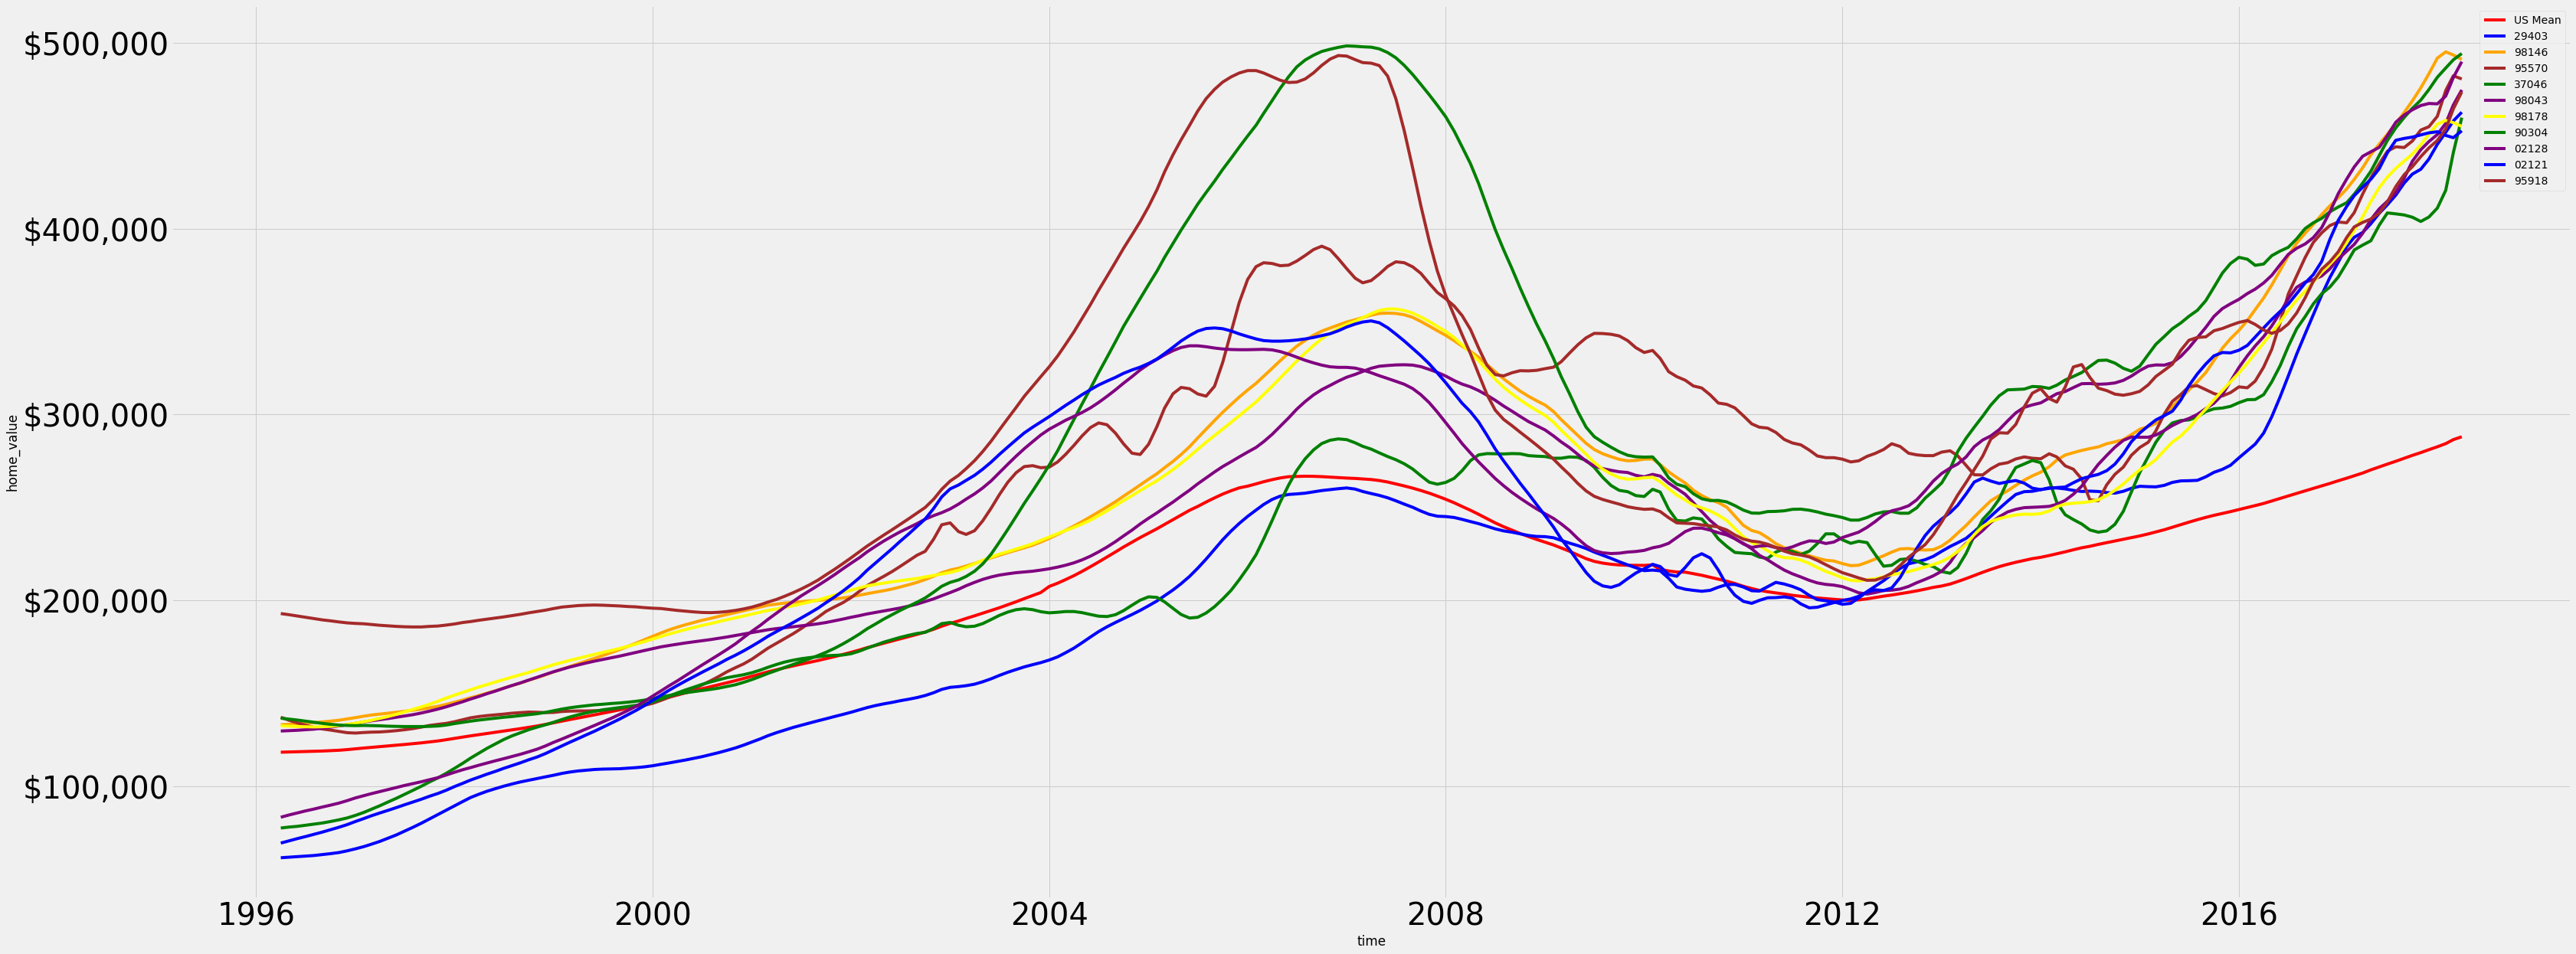

In [127]:
fig, ax = plt.subplots(figsize=(50, 20))

line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');
line2 = sns.lineplot(data=zip_29403_ts, x='time', y='value', color='blue', label='29403');
line3 = sns.lineplot(data=zip_98146_ts, x='time', y='value', color='orange', label='98146');
line4 = sns.lineplot(data=zip_95570_ts, x='time', y='value', color='brown', label='95570');
line5 = sns.lineplot(data=zip_37046_ts, x='time', y='value', color='green', label='37046');
line6 = sns.lineplot(data=zip_98043_ts, x='time', y='value', color='purple', label='98043');
line7 = sns.lineplot(data=zip_98178_ts, x='time', y='value', color='yellow', label='98178');
line8 = sns.lineplot(data=zip_90304_ts, x='time', y='value', color='green', label='90304');
line9 = sns.lineplot(data=zip_02128_ts, x='time', y='value', color='purple', label='02128');
lin10 = sns.lineplot(data=zip_02121_ts, x='time', y='value', color='blue', label='02121');
line11 = sns.lineplot(data=zip_95918_ts, x='time', y='value', color='brown', label='95918');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01') #housing market crash begins
y2 = p.axvline('2012-01') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Analysis: 
- These Zips have avg home values that are increasing at a much higher rate than the national average.

# Getting Recent Data (last 6 years)

- I will now analyze the last 6 years of data. 
- I was going to do 5 years as it is a nice round number, but looking at the average housing mean value it clearly shows the market crash of 2008. The market began to trend upward again in 2012, so that is a good starting point for looking at recent data.

In [ ]:
recent_df['6yr_mean'] =  recent_df[recent_df.columns[7:]].apply(lambda x: x.mean(), axis=1)

In [ ]:
#recent_df

In [ ]:
#recent_data['6yr_mean'] = recent_data.apply(lambda x: x.mean(), axis=1)
recent_df['6yr_ROI'] = recent_df.apply(lambda x: x['2018-04'] - x['2012-01'], axis=1)
recent_df['6yr_ROI%'] = recent_df.apply(lambda x: x['6yr_ROI'] / x['2012-01'], axis=1)

In [ ]:
#recent_df

# Recent Data (starting after crash) Analysis

In [ ]:
#recent_df.head()

In [ ]:
#recent_df = top_75_df[['ZipCode', 'City', 'State', 'CountyName', '2013-01', '2018-04', '6yr_mean',
#                    '6yr_ROI', '6yr_ROI%']]

In [ ]:
recent_df.head()

In [ ]:
recent_df.info()

In [ ]:
#recent_df.sort_values('6yr_ROI', ascending=False).head(50)

In [ ]:
#recent_df.sort_values('6yr_ROI%', ascending=False).head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
p = sns.scatterplot(data=recent_df, x="6yr_ROI%", y="6yr_ROI");


p.set_xlabel("6yr_ROI %", fontsize = 20)
p.set_ylabel("6yr ROI Amount", fontsize = 20)



plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("6 Year ROI Amount vs ROI %", fontsize = 40)
plt.figsize=(50,25)

plt.show();

# Melting top zipcodes

In [ ]:
data = ts[ts['ZipCode'] == '85035']
melted_data = melt_data(data)
zip_85035_ts = melted_data
zip_85035_ts.head()

In [ ]:
data = ts[ts['ZipCode'] == '85008']
melted_data = melt_data(data)
zip_85008_ts = melted_data
zip_85008_ts.head()

In [ ]:
data = ts[ts['ZipCode'] == '94804']
melted_data = melt_data(data)
zip_94804_ts = melted_data
zip_94804_ts.head()

In [ ]:
data = ts[ts['ZipCode'] == '94601']
melted_data = melt_data(data)
zip_94601_ts = melted_data
zip_94601_ts.head()

In [ ]:
data = ts[ts['ZipCode'] == '94590']
melted_data = melt_data(data)
zip_94590_ts = melted_data
zip_94590_ts.head()

# Visual: Comparing top Zips to national average

In [ ]:
fig, ax = plt.subplots(figsize=(50, 20))

line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');
line2 = sns.lineplot(data=zip_85035_ts, x='time', y='value', color='blue', label='85035');
line3 = sns.lineplot(data=zip_85008_ts, x='time', y='value', color='orange', label='85008');
line4 = sns.lineplot(data=zip_94590_ts, x='time', y='value', color='brown', label='94590');
line5 = sns.lineplot(data=zip_94804_ts, x='time', y='value', color='green', label='94804');
line6 = sns.lineplot(data=zip_94601_ts, x='time', y='value', color='purple', label='94601');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01') #housing market crash begins
y2 = p.axvline('2012-01') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Analysis: 
- ROI is related to the value increase related to the original amount. So several of these high ROI Zip Codes are still below the national mean. 
- Perhaps I should filter for zips that are above the national mean, and then sort with  highest ROI Percentage.

In [ ]:
avg_home_recent = avg_home_df['2012':]

In [ ]:
avg_home_recent.mean()

In [ ]:
avg_home_recent.head()

In [ ]:
top_zips = recent_df[recent_df['6yr_mean'] >= 239000]

In [ ]:
top_zips.sort_values('6yr_ROI%', ascending=False).head(7)

In [ ]:
data_1 = ts[ts['ZipCode'] == '94606']
data_2 = ts[ts['ZipCode'] == '94089']
data_3 = ts[ts['ZipCode'] == '11216']

In [ ]:
zip_94606_ts = melt_data(data_1)
zip_94089_ts = melt_data(data_2)
zip_11216_ts = melt_data(data_3)

### Visual

In [ ]:
fig, ax = plt.subplots(figsize=(50, 20))

line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');
line2 = sns.lineplot(data=zip_94601_ts, x='time', y='value', color='blue', label='94601');
line3 = sns.lineplot(data=zip_94804_ts, x='time', y='value', color='orange', label='94804');
line4 = sns.lineplot(data=zip_94606_ts, x='time', y='value', color='brown', label='94606');
line5 = sns.lineplot(data=zip_94089_ts, x='time', y='value', color='green', label='94089');
line5 = sns.lineplot(data=zip_11216_ts, x='time', y='value', color='purple', label='11216');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01') #housing market crash begins
y2 = p.axvline('2012-01') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 


p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Analysis: 
- This looks better. 
- These 5 Zip codes are all doing better than the national mean, and have the highest ROI (by percentage).

# Top 5 Zips by ROI Amount

In [ ]:
top_zips.sort_values('6yr_ROI', ascending=False).head(15)

In [ ]:
data = ts[ts['ZipCode'] == '10021']
melted_data = melt_data(data)
zip_10021_ts = melted_data

In [ ]:
data = ts[ts['ZipCode'] == '10011']
melted_data = melt_data(data)
zip_10011_ts = melted_data

In [ ]:
data = ts[ts['ZipCode'] == '94027']
melted_data = melt_data(data)
zip_94027_ts = melted_data

In [ ]:
data = ts[ts['ZipCode'] == '90210']
melted_data = melt_data(data)
zip_90210_ts = melted_data

In [ ]:
data = ts[ts['ZipCode'] == '94301']
melted_data = melt_data(data)
zip_94301_ts = melted_data

In [ ]:
#data = ts[ts['ZipCode'] == '94002']
#melted_data = melt_data(data)
#zip_94002_ts = melted_data

In [ ]:
data = ts[ts['ZipCode'] == '94022']
melted_data = melt_data(data)
zip_94022_ts = melted_data

In [ ]:
zip_94022_ts

## Visual

In [ ]:
fig, ax = plt.subplots(figsize=(50, 20))

line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');

#line2 = sns.lineplot(data=zip_94601_ts, x='time', y='value', color='green', label='94601');
#line3 = sns.lineplot(data=zip_94804_ts, x='time', y='value', color='green', label='94804');
#line4 = sns.lineplot(data=zip_94606_ts, x='time', y='value', color='green', label='94606');
#line5 = sns.lineplot(data=zip_94089_ts, x='time', y='value', color='green', label='94089');
#line5 = sns.lineplot(data=zip_11216_ts, x='time', y='value', color='green', label='11216');

p = sns.lineplot(data=zip_10021_ts, x='time', y='value', color='blue', label='10021');
p = sns.lineplot(data=zip_10011_ts, x='time', y='value', color='green', label='10011');
p = sns.lineplot(data=zip_94027_ts, x='time', y='value', color='black', label='94027');
p = sns.lineplot(data=zip_90210_ts, x='time', y='value', color='brown', label='90210');
p = sns.lineplot(data=zip_94301_ts, x='time', y='value', color='purple', label='94301');
p = sns.lineplot(data=zip_94022_ts, x='time', y='value', color='orange', label='94022');


p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01') #housing market crash begins
y2 = p.axvline('2012-01') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 


p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

## Analysis:
- The first tick for this visual (2.5 million) is higher than the highest tick on the ROI Percentage graph ($1.6mil)!
- Assuming that this real estate investment firm has the resources to do so, they should focus on these high ROI zip codes.
- While the ROI percentage rates for are lower than the other group, they are comparable. However, the total home value is significantly higher, so the 6 year return is much higher.

## Next Steps
- Now that I know what Zip Codes I want to focus on, I will begin modeling.
- I will use my models to predict if these zip codes will continue to get such great ROI returns.
- I will then make my final recommendations.

# Modeling (5/12)

## National Home Price Model

In [ ]:
avg_home_df.head()

In [ ]:
avg_home_df.plot();

In [ ]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

# Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            avg_home_df, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

In [ ]:
# Manually split data.
SPLIT = int(avg_home_df.shape[0]*0.8)
train, test = avg_home_df[:SPLIT], avg_home_df[SPLIT:]

# Model
sarima_model_best = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model_best.summary()

In [ ]:
# Call plot_diagnostics() on the results calculated above 
sarima_model_best.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
pred = sarima_model_best.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
ax.legend()

ax.yaxis.set_major_formatter(tick) 

fig.tight_layout()

In [ ]:
pred.conf_int().head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower home_value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper home_value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

## Zip_94601 modeling

In [ ]:
zip_94601_ts.drop(columns=['RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], inplace=True)

In [ ]:
zip_94601_ts['time'] = pd.to_datetime(zip_94601_ts['time'])

In [ ]:
zip_94601_ts.info()

In [ ]:
zip_94601_ts.drop(columns=['ZipCode'], inplace=True)

In [ ]:
zip_94601_ts.set_index('time', inplace=True)

In [ ]:
zip_94601_ts.info()

In [ ]:
zip_94601_ts

### Claude Method

In [ ]:
zip_94601_ts.plot(figsize=(12,6));

In [ ]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

# Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_94601_ts, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

In [ ]:
combo

In [ ]:
# Manually split data.
SPLIT = int(zip_94601_ts.shape[0]*0.8)
train, test = zip_94601_ts[:SPLIT], zip_94601_ts[SPLIT:]

# Model
sarima_model_best = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model_best.summary()

In [ ]:
# Call plot_diagnostics() on the results calculated above 
sarima_model_best.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
pred = sarima_model_best.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
ax.legend()
fig.tight_layout()

In [ ]:
pred.conf_int().head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.legend()
fig.tight_layout()

# Archive

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_94601_ts,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# From Claude Fried notebook.
# Train test split by hand.

SPLIT = int(zip_94601_ts.shape[0]*0.8)
train, test = zip_94601_ts[:SPLIT], zip_94601_ts[SPLIT:]

sarima_model_best = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model_best.summary()

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 6), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# Get predictions starting at 2005-01-01 (3 yrs of predictions) and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2005-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = zip_94601_ts.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Prices')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 


plt.legend()

plt.show()

In [ ]:
# Get the real and predicted values
zip_94601_ts_forecasted = pred.predicted_mean
zip_94601_ts_truth = zip_94601_ts

# Compute the mean square error
mse = ((zip_94601_ts_forecasted - zip_94601_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

## Zip 94022 Model

In [ ]:
zip_94022_ts.set_index('time', inplace=True)

In [ ]:
zip_94022_ts.head()

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip_94022_ts,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_94022_ts, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# Get predictions starting and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = zip_94022_ts['1996-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Prices')
plt.legend()

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 


plt.show()

In [ ]:
# Get the real and predicted values
zip_94022_forecasted = pred.predicted_mean
zip_94022_truth = zip_94022_ts['2012-01-01':]

# Compute the mean square error
mse = ((zip_94022_forecasted - zip_94022_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = zip_94022_ts['2010-01-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-01-01'),zip_94022_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Home Values')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 


plt.legend()
plt.show()

# Archive

## Removing Trends

In [ ]:
# from Flatiron Phase 4: Removing Trends Lab

def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS)
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

## Looping Through Zip Codes

In [ ]:
zip_list = ts['ZipCode'].head()

In [ ]:
zip_list

In [ ]:
variable_1 = ts.iloc[:1, :]
variable_1

In [ ]:
melt_data(variable_1)

In [ ]:
variable_2 = ts.iloc[:2, :]
variable_2

In [ ]:
melt_data(variable_2)

## Creating Master TS for Modeling

In [ ]:
ts.head()

In [ ]:
zip_df = ts.drop(columns=['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

In [ ]:
zip_df.head(100)

In [ ]:
def melt_data_2(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    #melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted = pd.melt(df, id_vars=['ZipCode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted
#melted.groupby('time').aggregate({'value':'mean'})

In [ ]:
melted_zip_df = melt_data_2(zip_df)

In [ ]:
melted_zip_df[melted_zip_df['ZipCode'] == '10456']

In [ ]:
melted_zip_df

In [ ]:
melted_zip_df.info()

In [ ]:
melted_zip_df.set_index('time', inplace=True)

In [ ]:
melted_zip_df

In [ ]:
melted_zip_df.drop(columns=['ZipCode'], inplace=True)

In [ ]:
melted_zip_df

In [ ]:
master_model_ts = melted_zip_df

In [ ]:
master_model_ts.plot(figsize=(15, 6))
plt.show()
print(master_model_ts.head())

## Zip 94022 Test Model

In [ ]:
# making sure this zip code works
zip_94022_ts.head()
#zip_94022_ts_decomposed.head()

In [ ]:
zip_94022_ts.isna().sum()

In [ ]:
zip_94022_ts.dropna()

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip_94022_ts, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# Get predictions starting and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = zip_94022_ts['1996-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Prices')
plt.legend()

plt.show()

In [ ]:
# Get the real and predicted values
zip_94022_forecasted = pred.predicted_mean
zip_94022_truth = zip_94022_ts['2012-01-01':]

# Compute the mean square error
mse = ((zip_94022_forecasted - zip_94022_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = zip_94022_ts_decomposed['1996-01-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-01-01'),zip_94022_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Home Values')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
zip_94022_forecasted = pred_dynamic.predicted_mean
zip_94022_truth = zip_94022_ts_decomposed['2003-01-01':]

# Compute the mean square error
mse = ((zip_94022_forecasted - zip_94022_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

## Model of Avg Mean DF

In [ ]:
avg_home_df.head()

In [ ]:
stationarity_check(avg_home_df)

In [ ]:
decomposition = seasonal_decompose(np.log(avg_home_df))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(zip_94022_ts), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

### Analysis: 

In [ ]:
# Drop missing values from residuals 
avg_home_df_decompose = residual
avg_home_df_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(avg_home_df_decompose)

### Analysis:
- p-value is under .05, so it is stationary.

## Model

In [ ]:
avg_home_df.isna().sum()

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(avg_home_df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(avg_home_df, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
# Get predictions starting and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2003-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = avg_home_df['1996-01-01':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Prices')
plt.legend()

plt.show()

In [ ]:
# Get the real and predicted values
avg_home_df_forecasted = pred.predicted_mean
avg_home_df_truth = avg_home_df['2012-01-01':]

# Compute the mean square error
mse = ((avg_home_df_forecasted - avg_home_df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
# Plot the dynamic forecast with confidence intervals.

ax = avg_home_df['1996-01-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-01-01'),avg_home_df_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Home Values')

plt.legend()
plt.show()

## Capturing CA values as a test for modeling

In [ ]:
ts.head()

In [ ]:
ca_df = ts[ts['State'] == 'CA']

In [ ]:
ca_zips = ca_df.drop(columns=['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

In [ ]:
ca_zips.info()

In [ ]:
ca_zips_melted = melt_data_2(ca_zips)

In [ ]:
ca_zips_melted

In [ ]:
ca_zips_melted.info()

In [ ]:
ca_zips_melted.set_index('time', inplace=True)

In [ ]:
ca_zips_melted.head()

In [ ]:
ca_zips_melted.drop(columns=['ZipCode'], inplace=True)

In [ ]:
ca_zip_ts = ca_zips_melted

## Modeling CA Zips

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
 #           mod = sm.tsa.statespace.SARIMAX(ca_zip_ts,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

## Running the big Model

In [ ]:
master_model_ts

In [ ]:
master_model_ts.tail()